# 01 — Dataset Statistics

Overview of the full dataset: subject counts, recording availability, neuron counts, session durations.

In [1]:
from remapping.dataset import (
    MiceDataset, Animals, GROUP_ORDER, SESSION_ORDER,
    EXPERIMENT_ORDER, COLORS_EXPERIMENTS, SESSION_COLORS,
    SESSION_TYPE_MAP, EXPERIMENT_TYPE_ORDER, EXPERIMENT_TYPE_COLORS,
)
from remapping.plotting import PlotStyle, get_figures_path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

mice = MiceDataset()
style = PlotStyle()
palette = mice.get_group_palette()

fig_path = get_figures_path("0.data_overview", "01_experiments_data_statistics")

## 1. Subjects per group

In [2]:
rows = []
for genotype in mice.get_genotypes():
    for age in mice.get_ages():
        group = mice.get_subjects_by_group(genotype, age)
        rows.append({
            "Genotype": genotype,
            "Age": age,
            "Count": len(group),
            "IDs": ", ".join(s.value for s in group),
        })

df_groups = pd.DataFrame(rows)
df_groups

,Genotype,Age,Count,IDs
0,5xFAD,old,6,"m111, m118, m125, m139, m140, m141"
1,5xFAD,young,5,"m77, m79, m121, m128, m132"
2,WT,old,6,"m62, m66, m70, m116, m117, m133"
3,WT,young,6,"m120, m127, m129, m130, m134, m135"


## 2. FOVs, sessions & runs per subject

In [ ]:
summary_rows = []
for subject in mice.get_all_subjects():
    info = mice.get_subject_info(subject)
    fovs = mice.get_available_fovs(subject)
    n_sessions = 0
    n_runs = 0
    for fov in fovs:
        sessions = mice.get_available_sessions(subject, fov)
        n_sessions += len(sessions)
        for session in sessions:
            n_runs += len(mice.get_available_runs(subject, fov, session))
    summary_rows.append({
        "Subject": subject.value,
        "Genotype": info["genotype"],
        "Age": info["age"],
        "FOVs": len(fovs),
        "Sessions": n_sessions,
        "Runs": n_runs,
    })

df_summary = pd.DataFrame(summary_rows)
df_summary

,Subject,Genotype,Age,FOVs,Sessions,Runs
0,m62,WT,old,1,3,6
1,m66,WT,old,1,2,4
2,m70,WT,old,1,3,6
3,m116,WT,old,1,3,9
4,m117,WT,old,1,2,4
5,m133,WT,old,1,1,3
6,m120,WT,young,3,9,21
7,m127,WT,young,2,6,18
8,m129,WT,young,2,6,18
9,m130,WT,young,2,6,18


## 3. Number of neurons per session (bar chart by group)

In [4]:
neuron_rows = []
for subject in mice.get_all_subjects():
    info = mice.get_subject_info(subject)
    for fov in mice.get_available_fovs(subject):
        for session in mice.get_available_sessions(subject, fov):
            runs = mice.get_available_runs(subject, fov, session)
            run = runs[0]  # neuron count is the same for all runs in a session
            n_neurons = mice.get_n_neurons(subject, fov, session, run)
            neuron_rows.append({
                "Subject": subject.value,
                "Group": f"{info['genotype']}_{info['age']}",
                "FOV": fov,
                "Session": session,
                "Experiment_type": SESSION_TYPE_MAP[session],
                "N_neurons": n_neurons,
            })

df_neurons = pd.DataFrame(neuron_rows)
print(f"Total FOV × session recordings: {len(df_neurons)}")
df_neurons.head()

Total FOV × session recordings: 117


,Subject,Group,FOV,Session,Experiment_type,N_neurons
0,m62,WT_old,2,fam1fam2,fam1 → fam2,292
1,m62,WT_old,2,fam1nov,fam1 → novel,247
2,m62,WT_old,2,fam1fam1rev,fam1 → reversed,232
3,m66,WT_old,1,fam1fam2,fam1 → fam2,168
4,m66,WT_old,1,fam1nov,fam1 → novel,166


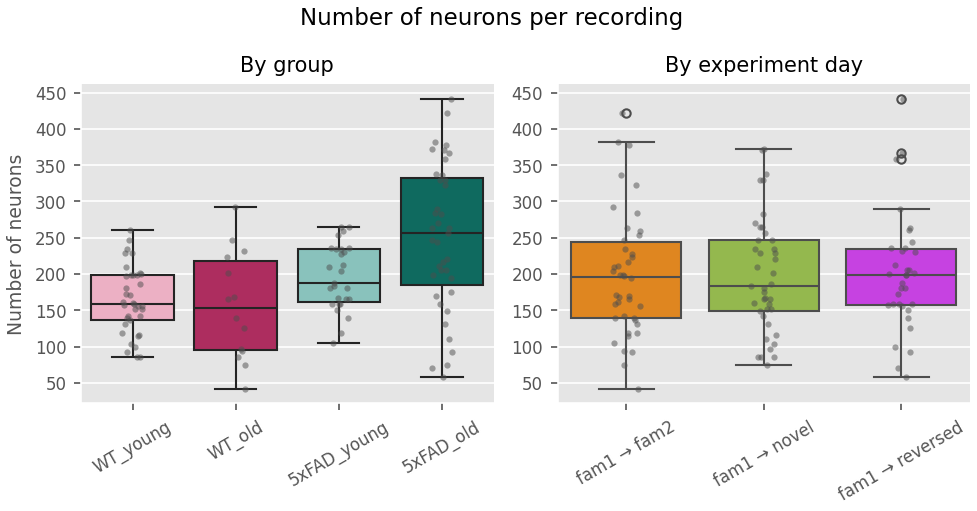

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(PlotStyle.FULL_WIDTH, 3.5), width_ratios=[1, 1])

# Left: by genotype × age group
sns.boxplot(
    data=df_neurons, x="Group", y="N_neurons", hue="Group",
    order=GROUP_ORDER, palette=palette, ax=axes[0], legend=False,
)
sns.stripplot(
    data=df_neurons, x="Group", y="N_neurons",
    order=GROUP_ORDER, color=".3", size=3, ax=axes[0], alpha=0.5,
)
axes[0].set_ylabel("Number of neurons")
axes[0].set_xlabel("")
axes[0].set_title("By group")
axes[0].tick_params(axis="x", rotation=30)

# Right: by experiment type (fam→fam, fam→nov, fam→rev)
sns.boxplot(
    data=df_neurons, x="Experiment_type", y="N_neurons", hue="Experiment_type",
    order=EXPERIMENT_TYPE_ORDER, palette=EXPERIMENT_TYPE_COLORS, ax=axes[1], legend=False,
)
sns.stripplot(
    data=df_neurons, x="Experiment_type", y="N_neurons",
    order=EXPERIMENT_TYPE_ORDER, color=".3", size=3, ax=axes[1], alpha=0.5,
)
axes[1].set_ylabel("")
axes[1].set_xlabel("")
axes[1].set_title("By experiment day")
axes[1].tick_params(axis="x", rotation=30)

fig.suptitle("Number of neurons per recording")
plt.tight_layout()
fig.savefig(fig_path / "neurons_per_recording.pdf")
plt.show()

## 4. Session-type counts

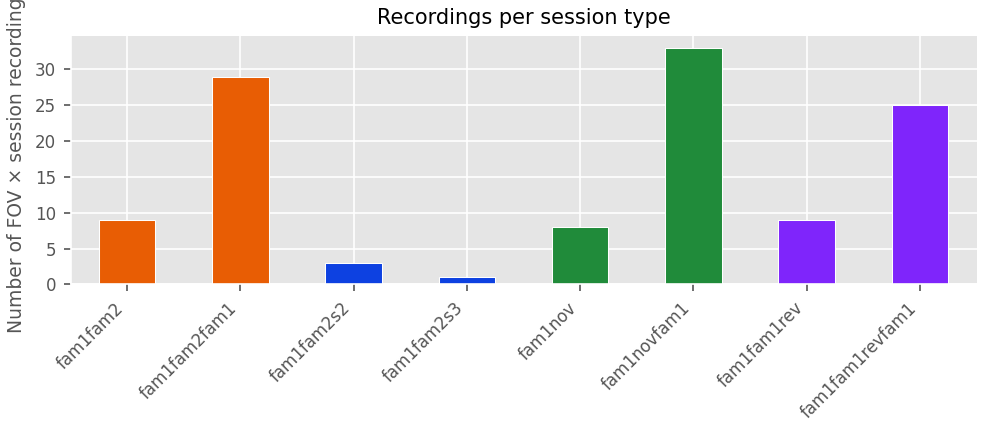

In [6]:
session_counts = df_neurons["Session"].value_counts()
# Reindex by canonical order (missing sessions get 0)
ordered_sessions = [s for s in SESSION_ORDER if s in session_counts.index]
session_counts = session_counts.reindex(ordered_sessions, fill_value=0)

bar_colors = [SESSION_COLORS.get(s, "#888888") for s in ordered_sessions]

fig, ax = plt.subplots(figsize=(PlotStyle.FULL_WIDTH, 3.0))
session_counts.plot.bar(ax=ax, color=bar_colors, edgecolor="white", linewidth=0.5)
ax.set_ylabel("Number of FOV × session recordings")
ax.set_xlabel("")
ax.set_title("Recordings per session type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
fig.savefig(fig_path / "session_type_counts.pdf")
plt.show()

## 5. FOVs per session type (availability heatmap)

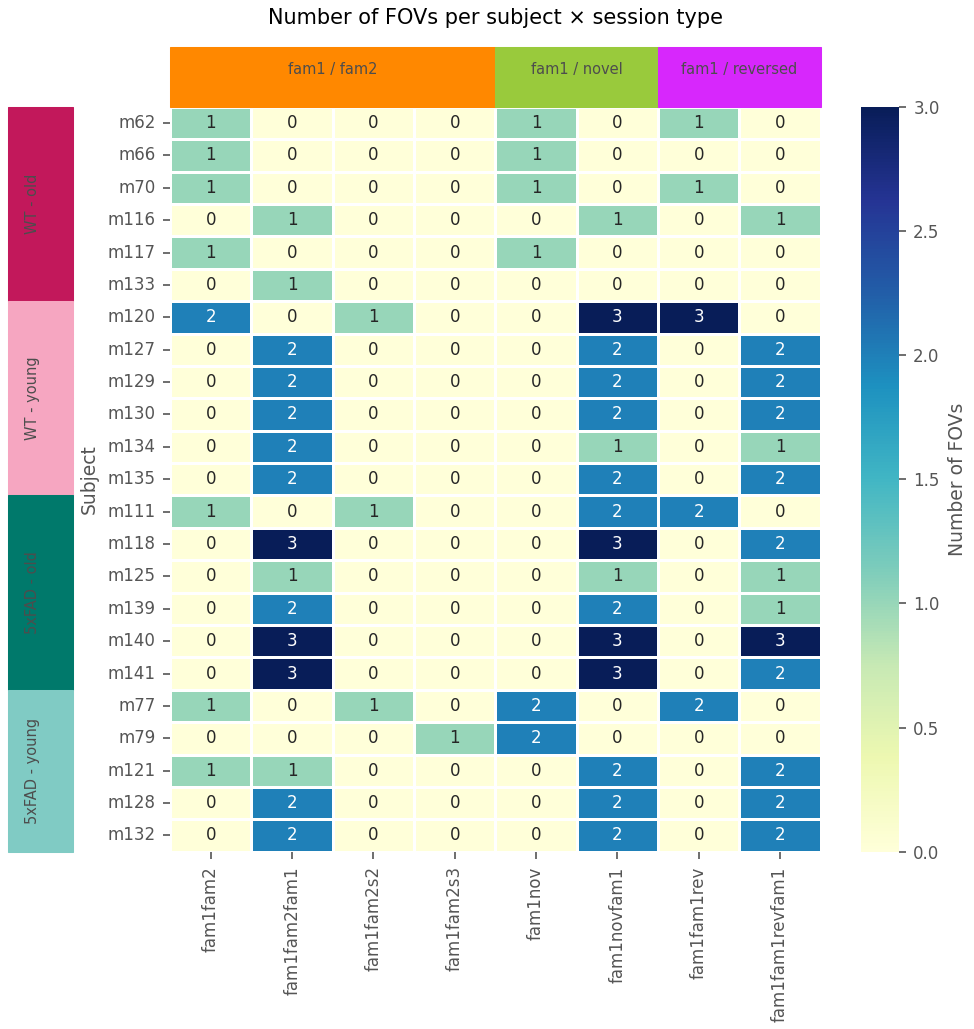

In [7]:
# Count distinct FOVs per subject × session type
ordered_sessions = [s for s in SESSION_ORDER if s in df_neurons["Session"].unique()]
all_subjects = [s.value for s in mice.get_all_subjects()]

avail = pd.DataFrame(0, index=all_subjects, columns=ordered_sessions)
for _, row in df_neurons.iterrows():
    if row["Session"] in avail.columns:
        avail.loc[row["Subject"], row["Session"]] += 1

# Group subjects by genotype × age for readability
subject_info = {s.value: mice.get_subject_info(s) for s in mice.get_all_subjects()}
group_labels = [f"{subject_info[s]['genotype']}_{subject_info[s]['age']}" for s in all_subjects]

fig, ax = plt.subplots(figsize=(PlotStyle.FULL_WIDTH, 7))
sns.heatmap(
    avail, cmap="YlGnBu", annot=True, fmt="d", linewidths=0.5,
    vmin=0, vmax=avail.values.max(), ax=ax,
    cbar_kws={"label": "Number of FOVs"},
)

# --- Left: group color bar + labels ---
GROUP_DISPLAY = {
    "WT_young": "WT - young", "WT_old": "WT - old",
    "5xFAD_young": "5xFAD - young", "5xFAD_old": "5xFAD - old",
}
for i, (s, g) in enumerate(zip(all_subjects, group_labels)):
    color = palette.get(g, "#888888")
    ax.add_patch(plt.Rectangle((-0.25, i), 0.1, 1, color=color, clip_on=False, transform=ax.get_yaxis_transform()))

# Find contiguous spans for each group and place a centered label
prev_g, span_start = group_labels[0], 0
for i in range(1, len(group_labels) + 1):
    cur_g = group_labels[i] if i < len(group_labels) else None
    if cur_g != prev_g:
        mid_y = (span_start + i) / 2
        ax.text(-0.20, mid_y, GROUP_DISPLAY.get(prev_g, prev_g),
                ha="right", va="center", fontsize=7, color="0.3",
                rotation=90, transform=ax.get_yaxis_transform())
        span_start = i
        prev_g = cur_g

# --- Bottom: experiment-type color bar + labels ---
EXP_DISPLAY = {
    "fam1 → fam2": "fam1 / fam2",
    "fam1 → novel": "fam1 / novel",
    "fam1 → reversed": "fam1 / reversed",
}
exp_labels = [SESSION_TYPE_MAP[s] for s in ordered_sessions]

for j, session in enumerate(ordered_sessions):
    exp_type = SESSION_TYPE_MAP[session]
    color = EXPERIMENT_TYPE_COLORS[exp_type]
    ax.add_patch(plt.Rectangle((j, 1.0), 1, 0.08, color=color, clip_on=False, transform=ax.get_xaxis_transform()))

# Find contiguous spans for each experiment type and place a centered label
prev_e, span_start = exp_labels[0], 0
for j in range(1, len(exp_labels) + 1):
    cur_e = exp_labels[j] if j < len(exp_labels) else None
    if cur_e != prev_e:
        mid_x = (span_start + j) / 2
        ax.text(mid_x, 1.04, EXP_DISPLAY.get(prev_e, prev_e),
                ha="center", va="bottom", fontsize=7, color="0.3",
                transform=ax.get_xaxis_transform())
        span_start = j
        prev_e = cur_e

ax.set_title("Number of FOVs per subject × session type", pad=40)
ax.set_ylabel("Subject")
ax.set_xlabel("")
plt.tight_layout()
fig.savefig(fig_path / "availability_heatmap.pdf")
plt.show()

## 6. Session duration distribution

In [8]:
duration_rows = []
for subject in mice.get_all_subjects():
    info = mice.get_subject_info(subject)
    for fov in mice.get_available_fovs(subject):
        for session in mice.get_available_sessions(subject, fov):
            for run in mice.get_available_runs(subject, fov, session):
                dur = mice.get_duration(subject, fov, session, run)
                duration_rows.append({
                    "Subject": subject.value,
                    "Group": f"{info['genotype']}_{info['age']}",
                    "Session": session,
                    "Run": run,
                    "Duration_s": dur,
                })

df_dur = pd.DataFrame(duration_rows)
print(f"Total runs: {len(df_dur)}")
df_dur.describe()

Total runs: 321


,Duration_s
count,321.000000
mean,1093.792961
std,541.956125
min,240.097087
25%,720.355987
50%,960.485437
75%,1440.711974
max,3121.650485


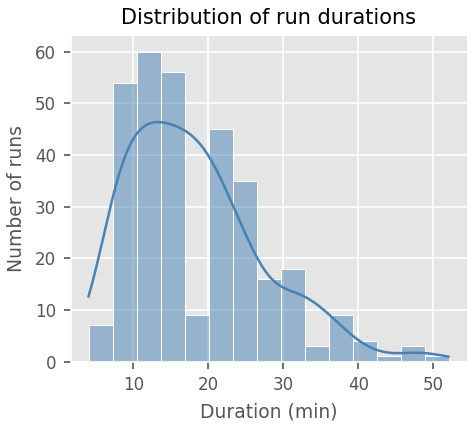

In [9]:
df_dur["Duration_min"] = df_dur["Duration_s"] / 60

fig, ax = plt.subplots(figsize=(PlotStyle.HALF_WIDTH, 3.0))
sns.histplot(
    df_dur["Duration_min"], bins=15, kde=True,
    ax=ax, color="steelblue", edgecolor="white", linewidth=0.5,
)
ax.set_xlabel("Duration (min)")
ax.set_ylabel("Number of runs")
ax.set_title("Distribution of run durations")
plt.tight_layout()
fig.savefig(fig_path / "run_duration_distribution.pdf")
plt.show()

## 7. Total recording time per group

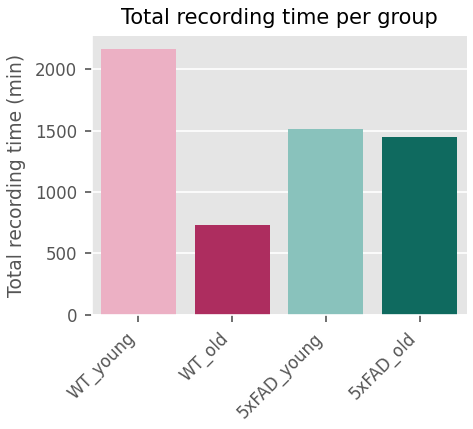

In [10]:
group_dur = df_dur.groupby("Group")["Duration_s"].sum().reset_index()
group_dur["Duration_min"] = group_dur["Duration_s"] / 60

fig, ax = plt.subplots(figsize=(PlotStyle.HALF_WIDTH, 3.0))
sns.barplot(
    data=group_dur, x="Group", y="Duration_min", hue="Group",
    order=GROUP_ORDER, palette=palette, ax=ax, legend=False,
)
ax.set_ylabel("Total recording time (min)")
ax.set_xlabel("")
ax.set_title("Total recording time per group")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
fig.savefig(fig_path / "total_recording_time.pdf")
plt.show()